<a href="https://colab.research.google.com/github/raghavadevarajeurs/DeepLearning/blob/main/Assignment3/Assignment3_PartB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building 3 layer Neural Network using Pytorch tensor with autodifferentiation primitives

In [1]:
import torch
import matplotlib.pyplot as plt
import plotly.graph_objects as pltgo

from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE

#Generating sample data for 3d input and 2d output


In [2]:
def get_true_labels(X, weights_true, bias_true):
  return (X ** 2) @ weights_true.T + X @ weights_true.T + bias_true.T

In [3]:
n_samples = 150
input_dim = 3
output_dim = 2

torch.manual_seed(1234)
max = 1
min = -1
X = (max - min) * torch.rand((n_samples, input_dim)) + min
print('Sample X: ' + str(X[:2]))

weights_true = torch.tensor([[5., 1., 3.], [2., 1., 1.]])
bias_true = torch.tensor([[1.], [1.]])

y_true = get_true_labels(X, weights_true, bias_true)
print('Sample Y: ' + str(y_true[:2]))

Sample X: tensor([[-0.9420, -0.1962, -0.4803],
        [-0.2667, -0.8834,  0.4013]])
Sample Y: tensor([[-0.1795,  0.4835],
        [ 1.6061,  1.0682]])


#Drawing the 3 Dimensional data plot

In [4]:
def plot_3d(title, X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=1234).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
  plt.legend()
  plt.show()

In [5]:
def plot_go_3d(x, y, y_pred=None):
  
  fig = pltgo.Figure()
  fig.add_trace(pltgo.Scatter3d(x = x[:,0], y = x[:,1], z = y.reshape([-1]),
                    name='y_true', mode='markers', marker=dict( size=10, color='dodgerblue', colorscale='Viridis', opacity=0.5)))
  if y_pred is not None:
    fig.add_trace(pltgo.Scatter3d(x = x[:,0], y = x[:,1], z = y_pred.reshape([-1]),
                   name='y_pred', mode='markers', marker=dict( size=10, color='goldenrod', colorscale='Viridis', opacity=0.5)))
  fig.update_layout(margin=dict(r=20, b=10, l=10, t=10))
  fig.show()

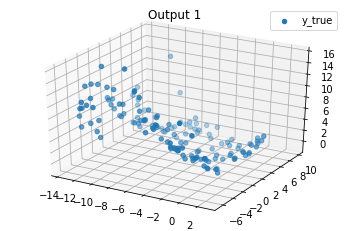

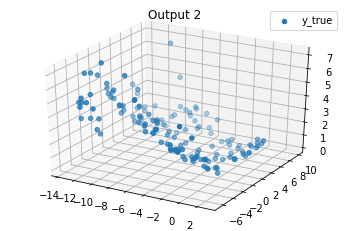

In [6]:
plot_3d('Output 1', X, y_true[:,0])
plot_3d('Output 2', X, y_true[:,1])

In [7]:
X_reduced = TSNE(n_components=2).fit_transform(X)
y_true_reduced = TSNE(n_components=1).fit_transform(y_true)
plot_go_3d(X_reduced,y_true_reduced)

#Build Neural Network

##Loss Function - MSE

In [8]:
# Mean Squared Error
class MSE:
  def __init__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
  
  def get_error(self):
    n = self.y_true.shape[0]
    return ((self.y_pred - self.y_true) ** 2) / n
  
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2.0 * (self.y_pred - self.y_true) / n
    return self.gradient

##Linear Layer

In [9]:
class Layer:
   #Randomly initialize the weight and bias
  def __init__(self, num_input_nodes=1, num_output_nodes=1, activation=None):
    self.num_input_nodes = num_input_nodes
    self.num_output_nodes = num_output_nodes
    self.weights = (max - min) * torch.rand((num_input_nodes, num_output_nodes), requires_grad=True) + min
    self.bias = torch.rand((1), requires_grad=True)
    self.X = torch.ones((num_input_nodes))
    if activation == 'relu':
      self.activation = Relu()
    else: 
      self.activation = None

  #Compute forward pass
  def forward(self, X):
    self.X = X
    self.Z = self.X @ self.weights + self.bias
    self.weights.retain_grad()
    self.bias.retain_grad()
    if self.activation == None:
      return self.Z 
    else:
      return self.activation.forward(self.Z)

  #Perform gradient descent
  def backward(self):
    self.dJdW = self.weights.grad
    self.dJdb = self.bias.grad

  # Update weight and bias params with learning rate
  def update(self, lr):
    self.weights = self.weights - lr * self.dJdW
    self.bias = self.bias - lr * self.dJdb

  def __str__(self):
    return 'Layer: ({},{}) Activation Function: {}\nInputs:\n{}\nWeights:\n{}\nBias:{}'.format(self.num_input_nodes, self.num_output_nodes, self.activation, self.X[:2], self.weights, self.bias)

##ReLU Activation function

In [10]:
class Relu:
  def __init__(self):
    self.input = torch.tensor([])

  #Forward pass
  def forward(self, input):
    self.input = input
    self.output = torch.clamp(self.input, min=0)
    return self.output
  
  # Auto differentiation takes care of this thus no explicit backward call is not needed
  def backward(self, upstream_gradient):
    return
  
  #Explicit update is not required
  def update(self, lr):
    return

  def __str__(self):
    return 'ReLU'

##Neural Net Architecture

In [11]:
class NeuralNet:
  def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs

    layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]
    
    self.layers = []
    for i in range(len(layers[:-1])):
      if i == len(layers[:-1]) - 1:
        self.layers.append(Layer(layers[i], layers[i + 1], activation=None))
      else:
        self.layers.append(Layer(layers[i], layers[i + 1], activation))

    print('Neural Net Architecture:')
    for i, layer in enumerate(self.layers):
      print('=== Layer {} ==='.format(i))
      print(layer)
    print()

  def forward(self, inputs):
    curr_out = inputs
    for l in self.layers:
      curr_out = l.forward(curr_out)

    return curr_out
  
  def backward(self, y_pred, y_true):
    external_grad = torch.ones(y_true.shape)

    mse = MSE(y_pred, y_true)
    error = mse.get_error()
    print('Error: ', mean_squared_error(y_true, y_pred.detach().numpy()))
    error.backward(gradient=external_grad, retain_graph=True)

    for layer in reversed(self.layers):
      layer.backward()
    
  def update(self, lr):
    for layer in self.layers:
      layer.update(lr)
  
  def fit(self, X, y_true, epochs):
    for i in range(epochs):
      y_pred = self.forward(X)
      self.backward(y_pred, y_true)
      self.update(lr)

  def __str__(self):
    s = [str(layer) for layer in self.layers]
    return '\n'.join(s)

#HyperParameters

In [12]:
epochs = 150
lr = 0.01

n_inputs = X.shape[1]
n_outputs = y_true.shape[1]

#Training NN withuot any activation function

In [13]:
nn = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation=None)
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X).detach().numpy()

err = mean_squared_error(y_true, y_pred)
print('Final Mean Squared Error: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
Layer: (3,4) Activation Function: None
Inputs:
tensor([1., 1.])
Weights:
tensor([[-0.3718,  0.1845,  0.2074,  0.9950],
        [-0.0362, -0.8093, -0.6606, -0.9213],
        [-0.1833,  0.1146,  0.3300,  0.1908]], grad_fn=<AddBackward0>)
Bias:tensor([0.6148], requires_grad=True)
=== Layer 1 ===
Layer: (4,3) Activation Function: None
Inputs:
tensor([1., 1.])
Weights:
tensor([[ 0.1383, -0.0887, -0.4486],
        [ 0.2358,  0.1317, -0.2811],
        [ 0.7287, -0.9732,  0.2939],
        [-0.5645,  0.5293,  0.7821]], grad_fn=<AddBackward0>)
Bias:tensor([0.8542], requires_grad=True)
=== Layer 2 ===
Layer: (3,2) Activation Function: None
Inputs:
tensor([1., 1.])
Weights:
tensor([[ 0.3834, -0.4775],
        [-0.2205, -0.2805],
        [ 0.1210, -0.4854]], grad_fn=<AddBackward0>)
Bias:tensor([0.7431], requires_grad=True)

Error:  16.385263
Error:  14.62089
Error:  13.374514
Error:  12.39876
Error:  11.583547
Error:  10.874518
Error:  10.244007
Error:  9.67

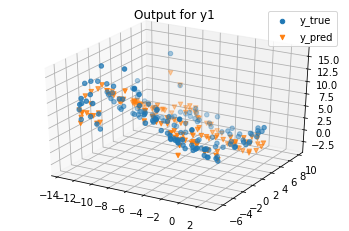

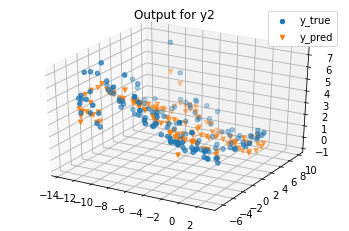

In [14]:
plot_3d('Output for y1', X, y_true[:,0], y_pred[:,0])
plot_3d('Output for y2', X, y_true[:,1], y_pred[:,1])

In [15]:
X_plot = TSNE(n_components=2).fit_transform(X)
y_true_plot = TSNE(n_components=1).fit_transform(y_true)
y_pred_plot = TSNE(n_components=1).fit_transform(y_pred)
plot_go_3d(X_plot,y_true_plot,y_pred_plot)

#Training NN with ReLU activation function

In [16]:
nn = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation='relu')
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X).detach().numpy()

err = mean_squared_error(y_true, y_pred)
print('Final Mean Squared Error: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
Layer: (3,4) Activation Function: ReLU
Inputs:
tensor([1., 1.])
Weights:
tensor([[ 0.5824, -0.4049, -0.2881, -0.7026],
        [-0.5554, -0.4922,  0.6965, -0.8546],
        [ 0.2994,  0.8967, -0.6644, -0.8817]], grad_fn=<AddBackward0>)
Bias:tensor([0.7710], requires_grad=True)
=== Layer 1 ===
Layer: (4,3) Activation Function: ReLU
Inputs:
tensor([1., 1.])
Weights:
tensor([[ 0.6124,  0.4185,  0.7880],
        [ 0.6322, -0.1554,  0.7401],
        [-0.5029,  0.4279, -0.6031],
        [ 0.2244,  0.5401,  0.3741]], grad_fn=<AddBackward0>)
Bias:tensor([0.7723], requires_grad=True)
=== Layer 2 ===
Layer: (3,2) Activation Function: None
Inputs:
tensor([1., 1.])
Weights:
tensor([[-0.1510,  0.3432],
        [ 0.1277,  0.8324],
        [ 0.5818, -0.7254]], grad_fn=<AddBackward0>)
Bias:tensor([0.6962], requires_grad=True)

Error:  11.632124
Error:  10.609804
Error:  9.907944
Error:  9.434029
Error:  9.097887
Error:  8.830874
Error:  8.592277
Error:  8.36389

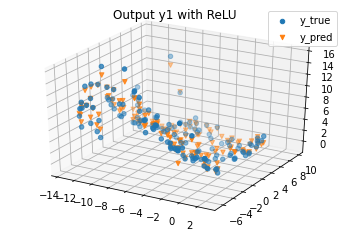

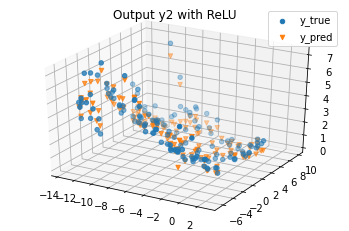

In [17]:
plot_3d('Output y1 with ReLU', X, y_true[:,0], y_pred[:,0])
plot_3d('Output y2 with ReLU', X, y_true[:,1], y_pred[:,1])

In [18]:
X_plot = TSNE(n_components=2).fit_transform(X)
y_true_plot = TSNE(n_components=1).fit_transform(y_true)
y_pred_plot = TSNE(n_components=1).fit_transform(y_pred)
plot_go_3d(X_plot,y_true_plot,y_pred_plot)